In [47]:
# coding: utf8
# -*- coding: UTF-8 -*-

import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
import codecs

fileAllRecords = codecs.open (r'Path.txt',
            "r",  encoding = 'utf-8')

allStrings = fileAllRecords.readlines()
new_file = codecs.open(r'Path', 'w',   encoding = 'utf-8')

for string in allStrings:
    if len(string) > 20:
        new_file.write(string)

full_new_corpus = open(r'Path.txt', 'r',  encoding = 'utf-8')
lines = full_new_corpus.readlines()

sentences = []
for sent_str in lines:
    tokens = re.sub("[a-z0-9]+.,´-", " ", sent_str.lower()).split()
    sentences.append(tokens)

from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, vector_size=50, window=4, min_count=3, workers=4, sg=0)
model.train(sentences, total_examples=len(sentences), epochs=100)
model.save('model_1.bin')

In [48]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras import optimizers

from keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

import pandas
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

#get data in words
some_data = pandas.read_csv(r"test.csv",
                            sep=' ; ', encoding = 'utf-8', engine='python', index_col=False)

labels = some_data.iloc[:,0]
samples = some_data.iloc[:,1]

print(samples);

num_of_diagnoses = len(set(labels))

0        Asthma with status asthmaticus (disorder)
1     Varicose veins of lower extremity (disorder)
2                             Gastritis (disorder)
3                           Hemorrhoids (disorder)
4                               Headache (finding)
5                        Lightheadedness (finding)
6         Benign essential hypertension (disorder)
7                                Fatigue (finding)
8                     Disorder of liver (disorder)
9                         Hiatal hernia (disorder)
10                        Cholecystitis (disorder)
11                       Pyelonephritis (disorder)
12             Diabetes mellitus type 2 (disorder)
13       Chronic ischemic heart disease (disorder)
14         Body mass index 30+ - obesity (finding)
15        Calculus of kidney and ureter (disorder)
16          Scoliosis of thoracic spine (disorder)
17                 Chronic pancreatitis (disorder)
18               Duodenal ulcer disease (disorder)
19                       Chroni

In [83]:
#convert labels to categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
Y_encoded = np_utils.to_categorical(encoded_labels)

import re 
import pymorphy2

def preprocessing_samples(samples):
    morph = pymorphy2.MorphAnalyzer()
    new_samples = []
    for s in samples:
        new_s = ""
        for w in s.split():
            r = re.compile("[^a-zA-Z ]+")
            w = r.sub('', w).lower()
            w = morph.parse(w)[0].normal_form  
            new_s += w + " "
        new_samples.append(new_s)
    return new_samples

samples = preprocessing_samples(samples) 


#Word2Vec load
def words_in_sample(samples):
    """Max number of words in one sample"""
    max_len = 0
    for sample in samples:
        cur_sample = sample.split()
        max_len = len(cur_sample) if len(cur_sample) > max_len else max_len
    return max_len

max_words_in_sample = words_in_sample(samples)
print("max_words_in_sample", max_words_in_sample)
print("samples", samples)


#load word2vec model
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

# my model
model = Word2Vec.load("model_1.bin") #model_2.bin

# rusvectors model
#word2vecModel = KeyedVectors.load_word2vec_format("model_1.bin", binary=True) 
word_vectors = model
word_vectors.save('vectors.kv')
word2vecModel = KeyedVectors.load('vectors.kv')

from collections import defaultdict
modelWord_from_word = dict()

vocab_len = len(model.wv)
print("vocab len", vocab_len);
for inx in range(vocab_len):
    print("inx", inx)
    print(word2vecModel.wv.index_to_key[inx])
    word = word2vecModel.wv.index_to_key[inx]
    #word = word2vecModel.wv.index_to_key(inx).split('_')[0]
    modelWord_from_word[inx + 1] = word;

from keras.preprocessing.text import text_to_word_sequence
from sklearn.metrics import accuracy_score

def get_embedded_samples(samples, word2vecModel, words_in_sample):
    """get word2vec embeddings for given samples and words absent in given word2vec model"""
    new_x = np.zeros((len(samples), word2vecModel.vector_size*words_in_sample))
    absent_words = []
    i = 0 
    for sample in samples:
        current_sample = text_to_word_sequence(sample)
        newcur_x = np.zeros((1, word2vecModel.vector_size*max_words_in_sample))
        j = 0
        for word in current_sample:
            if word in modelWord_from_word:
                newcur_x[:, j:j+word2vecModel.vector_size] = (word2vecModel[modelWord_from_word[word]])
                j += word2vecModel.vector_size
            else:
                absent_words.append(word)
        new_x[i] = newcur_x
        i += 1
    return new_x, absent_words

new_x, absentWords = get_embedded_samples(samples, word2vecModel, max_words_in_sample)

def create_network():
    model_CNN = Sequential([
        Conv2D(32, (3, 3), activation='relu',
               input_shape=(max_words_in_sample,
                            word2vecModel.vector_size,
                            1),
               data_format="channels_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        #Conv2D(64, (2, 2), activation='relu'),
        #MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_of_diagnoses, activation='softmax')])

    model_CNN.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return model_CNN

6
samples ['asthma with status asthmaticus disorder ', 'varicose veins of lower extremity disorder ', 'gastritis disorder ', 'hemorrhoids disorder ', 'headache finding ', 'lightheadedness finding ', 'benign essential hypertension disorder ', 'fatigue finding ', 'disorder of liver disorder ', 'hiatal hernia disorder ', 'cholecystitis disorder ', 'pyelonephritis disorder ', 'diabetes mellitus type disorder ', 'chronic ischemic heart disease disorder ', 'body mass index obesity finding ', 'calculus of kidney and ureter disorder ', 'scoliosis of thoracic spine disorder ', 'chronic pancreatitis disorder ', 'duodenal ulcer disease disorder ', 'chronic anemia disorder ', 'edema of lower extremity finding ', 'chronic kidney disease disorder ']
vocab len 458
inx 0
the
inx 1
of
inx 2
in
inx 3
is
inx 4
a
inx 5
/
inx 6
not
inx 7
-
inx 8
and
inx 9
l
inx 10
are
inx 11
with
inx 12
no
inx 13
1
inx 14
%
inx 15
times
inx 16
2
inx 17
on
inx 18
mmol/l
inx 19
to
inx 20
blood
inx 21
was
inx 22
left
inx 23
f

In [71]:
history_dict = history_CNN.history

In [72]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Epoch 1/10
1/1 [==============================] - 1s 868ms/step - loss: 3.0910 - accuracy: 0.0000e+00 - val_loss: 3.0959 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 3.0896 - accuracy: 0.0588 - val_loss: 3.0995 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 3.0886 - accuracy: 0.0588 - val_loss: 3.1024 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 58ms/step - loss: 3.0877 - accuracy: 0.0588 - val_loss: 3.1051 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 56ms/step - loss: 3.0870 - accuracy: 0.0588 - val_loss: 3.1075 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 58ms/step - loss: 3.0863 - accuracy: 0.0588 - val_loss: 3.1097 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 3.0856 - accuracy: 0.0588 - val_loss: 3.1119 - val_accuracy: 0.000

C:\Users\caast\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 3.0910 - accuracy: 0.0588 - val_loss: 3.0959 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 50ms/step - loss: 3.0896 - accuracy: 0.0588 - val_loss: 3.0995 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 3.0886 - accuracy: 0.0588 - val_loss: 3.1024 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 44ms/step - loss: 3.0877 - accuracy: 0.0588 - val_loss: 3.1051 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 46ms/step - loss: 3.0870 - accuracy: 0.0588 - val_loss: 3.1075 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 3.0863 - accuracy: 0.0588 - val_loss: 3.1097 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 57ms/step - loss: 3.0856 - accuracy: 0.0588 - val_loss: 3.1119 - val_accuracy: 0.0000e+00
Epoch 8/10
1

C:\Users\caast\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 3.0910 - accuracy: 0.0556 - val_loss: 3.0962 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 51ms/step - loss: 3.0899 - accuracy: 0.0556 - val_loss: 3.1000 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 3.0891 - accuracy: 0.0556 - val_loss: 3.1031 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 78ms/step - loss: 3.0884 - accuracy: 0.0556 - val_loss: 3.1059 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 68ms/step - loss: 3.0878 - accuracy: 0.0556 - val_loss: 3.1084 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 73ms/step - loss: 3.0872 - accuracy: 0.0556 - val_loss: 3.1108 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 3.0867 - accuracy: 0.0556 - val_loss: 3.1131 - val_accuracy: 0.0000e+00
Epoch 8/10
1

C:\Users\caast\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 3.0910 - accuracy: 0.0556 - val_loss: 3.0962 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 3.0899 - accuracy: 0.0556 - val_loss: 3.1000 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 45ms/step - loss: 3.0891 - accuracy: 0.0556 - val_loss: 3.1031 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 3.0884 - accuracy: 0.0556 - val_loss: 3.1059 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss: 3.0878 - accuracy: 0.0556 - val_loss: 3.1084 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 51ms/step - loss: 3.0872 - accuracy: 0.0556 - val_loss: 3.1108 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 51ms/step - loss: 3.0867 - accuracy: 0.0556 - val_loss: 3.1131 - val_accuracy: 0.0000e+00
Epoch 8/10
1

C:\Users\caast\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 965ms/step - loss: 3.0910 - accuracy: 0.0556 - val_loss: 3.0962 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 3.0899 - accuracy: 0.0556 - val_loss: 3.1000 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 3.0891 - accuracy: 0.0556 - val_loss: 3.1031 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 3.0884 - accuracy: 0.0556 - val_loss: 3.1059 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 65ms/step - loss: 3.0878 - accuracy: 0.0556 - val_loss: 3.1084 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 67ms/step - loss: 3.0872 - accuracy: 0.0556 - val_loss: 3.1108 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 62ms/step - loss: 3.0867 - accuracy: 0.0556 - val_loss: 3.1131 - val_accuracy: 0.0000e+00
Epoch 8/1

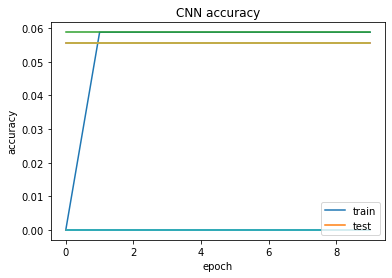

In [90]:
from sklearn.metrics import accuracy_score

n_splits = 5
n_epochs = 10

x_CNN = new_x.reshape(new_x.shape[0], max_words_in_sample, word2vecModel.vector_size, 1)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
kf.get_n_splits(x_CNN)

f1_score_all = []
for train_index, test_index in kf.split(x_CNN):
    X_train, X_test = x_CNN[train_index], x_CNN[test_index]
    y_train, y_test = Y_encoded[train_index], Y_encoded[test_index]

    model_CNN = create_network()

    history_CNN = model_CNN.fit(X_train, y_train,
                                epochs=n_epochs,
                                verbose=1,
                                batch_size = 128,
                                validation_data=(X_test, y_test))

    # summarize history for accuracy
    plt.plot(history_CNN.history['accuracy'])
    plt.plot(history_CNN.history['val_accuracy'])
    plt.title('CNN accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    # evaluate
    #accuracy_score(y, np.argmax(pred_train, axis=1))
    acc = model_CNN.evaluate(X_test, y_test, verbose = 0)[1]
    print("acc ", model_CNN.evaluate(X_test, y_test, verbose = 0)[1])
    pred_cnn = np.argmax(model_CNN.predict(X_test),axis=1)
    metrica = f1_score(np.argmax(y_test,axis =1), pred_cnn, average='micro')
    print("F1 ", metrica)
    f1_score_all.append(metrica)
    
    #_, accuracy += model_CNN.evaluate(X_train, y_train)

    
print(sum(f1_score_all)/len(f1_score_all))
print('Accuracy: %.2f' % (acc*100))
plt.show()